<i> Méndez Pool Joan de Jesús / 160300102</i>

# Morphing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from IPython.display import Image # Función para visualizar el GIF en el notebook
import cv2
import dlib
import os # Librería para el manejo de ficheros y directorios
import shutil # Librería para copiar ficheros o directorios
import imageio # Librería para la creación del GIF

Para realizar el morphing es necesario combinar/mezclar progresivamente las dos imágenes

* Controlamos la mezcla mediante un parámetro: $\alpha \in [0, 1]$
* Si $\alpha = 0$ entonces obtenemos la imagen inicial
* Si $\alpha = 1$ entonces obtenemos la imagen final

$$I_t = (1-\alpha)I_1 + \alpha I_2$$

El parámetro $\alpha$ cambiará progresivamente de cero a uno.

### Alineamos las imágenes

Para realizar el morphing además de combinar las intensidades es necesario alinear las imágenes a una **triangulación** que sirva de **referencia**.

La triangulación puede obtenerse transformando también gradualmente las triangulaciones de las dos imágenes.

Para algún valor de $\alpha$ obtenemos las coordenadas de cada punto de la triangulación de referencia mediante las siguientes ecuaciones

\begin{align}
    x_t &= (1-\alpha)x_1 + \alpha x_2\\
    y_t &= (1-\alpha)y_1 + \alpha y_2\\
\end{align}

donde $(x_1, \; y_1)$ son las coordenadas de algún punto de la primera triangulación y $(x_2, \; y_2)$ son las coordenadas del punto correspondiente en la segunda imagen.

#### Funciones utilizadas en los notebooks en clase

In [2]:
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()    
    w = rect.right() - x
    h = rect.bottom() - y
    
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
 
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    
    return coords

def rect2homog(pts):
    n = pts.shape[0]
    o = np.ones(n)
    return np.column_stack((pts,o))

def aplicaHomografia(pts, H):
    pts_h = rect2homog(pts)
    pts_t = np.dot(H,np.transpose(pts_h))
    pts_t_trans = np.transpose(pts_t)
    return normalizaPuntos(pts_t_trans)

def normalizaPuntos(pts_h):
    return np.column_stack((np.divide(pts_h[:,0],pts_h[:,2]),np.divide(pts_h[:,1],pts_h[:,2])))

#envía los índices del triángulo, 
#los puntos del triángulo en I1, 
#la imagen a transformar
def triangulo_transf(t, shape1, shape2, im):
    
    pt0_1 = (shape1[t[0]][0],shape1[t[0]][1])
    pt1_1 = (shape1[t[1]][0],shape1[t[1]][1])
    pt2_1 = (shape1[t[2]][0],shape1[t[2]][1])
    pts1 = np.array([pt0_1, pt1_1, pt2_1])
    
    pt0_2 = (shape2[t[0]][0],shape2[t[0]][1])
    pt1_2 = (shape2[t[1]][0],shape2[t[1]][1])
    pt2_2 = (shape2[t[2]][0],shape2[t[2]][1])
    pts2 = np.array([pt0_2, pt1_2, pt2_2])
    
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    
    #determina la transformación afín
    taf = cv2.getAffineTransform(pts2,pts1)        
    
    #determina la homografía
    H = np.append(taf,[[0,0,1]], axis=0)
       
    #transforma los puntos
    pts_t = aplicaHomografia(pts2,H)
    
    (m,n) = im.shape
    
    alpha = np.zeros((m,n))
    
    points = [[int(pts_t[0][1]-0.5),int(pts_t[1][1]-0.5), int(pts_t[2][1]-0.5)],[int(pts_t[0][0]-0.5), int(pts_t[1][0]-0.5), int(pts_t[2][0]-0.5)], [1,1,1]]
    
    for i in range(min(points[0]),max(points[0])):
        for j in range(min(points[1]),max(points[1])):            
            x = np.linalg.solve(points,[i,j,1])
            if min(x) > 0: #all coefficients positive
                alpha[i,j] = 1
    im_t = cv2.warpAffine(im,taf,(n,m))
    alpha[alpha>0] = im_t[alpha>0]

    return alpha

### Funciones definidas para la aplicación del Morphing a dos imágenes

In [3]:
def detectapuntos(im1, im2):
    #detecta los puntos de interés en ambas imágenes
    rects1 = detector(im1) 
    shape1 = predictor(im1, rects1[0])
    shape1 = shape_to_np(shape1)

    rects2 = detector(im2) 
    shape2 = predictor(im2, rects2[0])
    shape2 = shape_to_np(shape2)
    
    #extiende los puntos de interés de ambas imágenes
    shape1 = np.append(shape1,[[im1.shape[1]-1,im1.shape[0]/2],[im1.shape[1]/2,im1.shape[0]-1],[im1.shape[1]/2,0],[0,im1.shape[0]/2],[0,0],[im1.shape[1]-1,0],[0,im1.shape[0]-1],[im1.shape[1]-1,im1.shape[0]-1]], axis=0)
    shape2 = np.append(shape2,[[im2.shape[1]-1,im2.shape[0]/2],[im2.shape[1]/2,im2.shape[0]-1],[im2.shape[1]/2,0],[0,im2.shape[0]/2],[0,0],[im2.shape[1]-1,0],[0,im2.shape[0]-1],[im2.shape[1]-1,im2.shape[0]-1]], axis=0)
    return shape1, shape2

def Transforma_Imagens(im1, im2, shape_a, shape1, shape2):
    im_fin1 = np.zeros((im1.shape))
    im_fin2 = np.zeros((im2.shape))
    # Define la triangulación a la cual se deben alinear las imágenes
    for t in Delaunay(shape_a).simplices:    
        #transforma las imágenes alineando el triángulo y los extrae
        triang_tr1 = triangulo_transf(t, shape_a, shape1, im1)
        triang_tr2 = triangulo_transf(t, shape_a, shape2, im2)
        im_fin1 = im_fin1 + triang_tr1
        im_fin2 = im_fin2 + triang_tr2
    # Rellena los espacios vacíos de las imágenes
    im_fin1 = im_fin1.astype(np.uint8)
    im_fin1 = cv2.medianBlur(im_fin1,3)
    im_fin2 = im_fin2.astype(np.uint8)
    im_fin2 = cv2.medianBlur(im_fin2,3)
    return (im_fin1, im_fin2)

def Morphing(im1, im2, n=10, dirgif = 'GIF'):
    # Obtenemos los puntos de interés en ambas imágenes
    shape1, shape2 = detectapuntos(im1, im2)
    # Definimos nuestra secuencia de alpha
    alfa = np.linspace(0,1,n)
    # Escribimos la ruta del directorio para guardar las imágenes
    path = './' + dirgif + '/'
    # Definimos los nombres de la secuencia de las imágenes
    imgs = path + 'img'
    # Verificamos la existencia del directorio
    try:
        os.stat(dirgif)
    except:
        os.mkdir(dirgif)
    #plt.gray()    
    for i,a in enumerate(alfa):
        # Calculamos la triangulación a alinear las imágenes
        shape_a = (1-a)*shape1 + a*shape2
        shape_a = shape_a.astype(int)
        # Obtenemos las imágenes alineadas con dicha triangulación
        imc1, imc2 = Transforma_Imagens(im1, im2, shape_a, shape1, shape2)
        # Sobreponemos las imágenes de acuerdo al alpha (En este caso alpha define la transparecia de ambas imágenes)
        im_tr = (1-a)*imc1+a*imc2
        # Guardamos la imagen creada
        cv2.imwrite( imgs + str(i+1001) + '.png', im_tr)
        """plt.imshow(im_tr)
        plt.title("$\\alpha=$"+str(round(a,2)))
        plt.axis("off")    
        plt.show()"""

### Funciones para la visualización de los procedemientos realizados a las transformaciones de imágenes

In [4]:
def Show_Imags(im1, im2):
    imc1 = im1.copy()
    imc2 = im2.copy()
    plt.subplot(121)
    plt.imshow(imc1, cmap="gray")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(imc2, cmap="gray")
    plt.axis("off")
    plt.show()
def Show_Face_Detector(im1, im2):
    imc1 = im1.copy()
    imc2 = im2.copy()
    rects1 = detector(imc1) 
    rects2 = detector(imc2) 
    plt.subplot(121)
    # Dibuja rectángulo que limita la zona del rostro en la primera imagen
    (x, y, w, h)=rect_to_bb(rects1[0])
    cv2.rectangle(imc1, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(imc1, cmap="gray")
    plt.axis("off")
    plt.subplot(122)
    # Dibuja rectángulo que limita la zona del rostro en la segunda imagen
    (x, y, w, h)=rect_to_bb(rects2[0])
    cv2.rectangle(imc2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(imc2, cmap="gray")
    plt.axis("off")
    plt.show()
def Show_Points_of_Interest(im1, im2):
    imc1 = im1.copy()
    imc2 = im2.copy()
    shape1, shape2 = detectapuntos(imc1, imc2)
    # Dibuja los puntos de interés de las respectivas imágenes
    for (x1, y1),(x2, y2) in zip(shape1, shape2):
        cv2.circle(imc1, (x1, y1), 2, (0, 0, 255), -1)
        cv2.circle(imc2, (x2, y2), 2, (0, 0, 255), -1)
    plt.subplot(121)
    plt.imshow(imc1, cmap="gray")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(imc2, cmap="gray")
    plt.axis("off")
    plt.show()
def Show_Triangulation(im1, im2):
    imc1 = im1.copy()
    imc2 = im2.copy()
    shape1, shape2 = detectapuntos(imc1, imc2)
    tri =  Delaunay(shape1)
    for t in tri.simplices:
        # Dibujar Triangulación en la primera imagen
        pt0 = (shape1[t[0]][0],shape1[t[0]][1])
        pt1 = (shape1[t[1]][0],shape1[t[1]][1])
        pt2 = (shape1[t[2]][0],shape1[t[2]][1])
    
        cv2.line(imc1,pt0,pt1,(255,255,255),1)
        cv2.line(imc1,pt0,pt2,(255,255,255),1)
        cv2.line(imc1,pt1,pt2,(255,255,255),1)
        # Dibujar Triangulación en la segunda imagen
        pt0 = (shape2[t[0]][0],shape2[t[0]][1])
        pt1 = (shape2[t[1]][0],shape2[t[1]][1])
        pt2 = (shape2[t[2]][0],shape2[t[2]][1])
    
        cv2.line(imc2,pt0,pt1,(255,255,255),1)
        cv2.line(imc2,pt0,pt2,(255,255,255),1)
        cv2.line(imc2,pt1,pt2,(255,255,255),1)
    plt.subplot(121)
    plt.imshow(imc1, cmap="gray")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(imc2, cmap="gray")
    plt.axis("off")
    plt.show()

### Funciones para la creación y visualización de GIFs animados

In [5]:
def Crea_GIF(dirgif='GIF', namegif = 'jjmorphing.gif', dur=0.132):
    # Define la ruta del directorio
    path = './' + dirgif + '/'
    # Obtiene la lista de imágenes ordenada del directorio donde se crearon
    imc = [ cv2.imread(path + str(i),0) for i in sorted(os.listdir(path)) ]
    # Guarda el GIF animado
    imageio.mimsave(namegif, imc, format='GIF', duration=dur)
    
def Show_GIF(namegif, viso = 'viso.gif.png'):
    # Copiar archivo con extensión png para la visualización en el notebook
    shutil.copyfile(namegif, viso)  
    # Recuperación del GIF
    return Image(filename=viso, width=250, height=250)

### Construimos el Detector y Predictor de los puntos de interés

In [6]:
#detector de rostros
detector = dlib.get_frontal_face_detector() 
#detector de puntos de interés
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

## Aplicación del Morphing a las imágenes de Marilyn Monroe y la Mona Lisa
<br>
<p style="text-align:justify;">El primer paso es cargar las imágenes a trabajar y definir el mismo tamaño para ambas, de igual forma definimos el nombre de nuestro GIF animado y el directorio donde guardaremos las imágenes creadas durante el proceso de la transformación de la primera imagen a la segunda.</p>

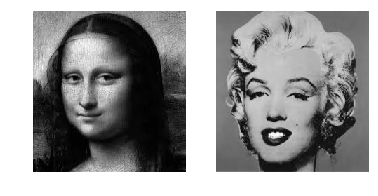

In [7]:
im1 = cv2.imread("mona.jpg",0)
im2 = cv2.imread("marilyn.jpg",0)
im2 = cv2.resize(im2,(im1.shape[1],im1.shape[0]))
namegif = 'morphing.gif'
dirname = 'Mona-Marilyn'
Show_Imags(im1, im2)

## Detectar Rostros

<p style="text-align:justify;">El primer paso de nuestro Algoritmo es delimitar la zona del rostro de ambas imágenes con el <i>Detector</i> definido con anterioridad obtenido de la librería <i>dlib</i> de <i>Python</i>, esto nos permite reducir el área de la zona donde se aplicará el <i>Predictor</i> para la recuperación de los puntos de interés sobre ambas imágenes.</p>

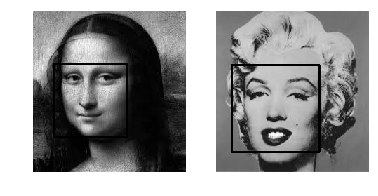

In [8]:
Show_Face_Detector(im1, im2)

## Recuperar puntos de interés

<p style="text-align:justify;"> Con el <i>Predictor</i> podemos recuperar los puntos de interés en la zona que rodea la cara de las personas en ambas imágenes, la recuperación de estos puntos es parte fundamental del Algoritmo ya que por medio de estos podemos alinear ambas imágenes entre si mismas para brindar el efecto de transformación de los rostros.</p>

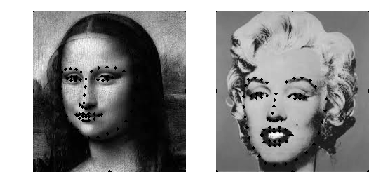

In [9]:
Show_Points_of_Interest(im1, im2)

## Triangulación de los puntos de interés

<p style="text-align:justify;"> Después de obtener los puntos interés aplicamos el <i>Algoritmo de Triangulación de Delaunay</i> para crear la triangulación sobre la nube de puntos, obteniendo dicha triangulación podemos reconstruir las imágenes de una trinagulación a otra, lo cual nos permite alinear los rostros durante el proceso de transformación que el <i>Morphing</i> realiza.</p>

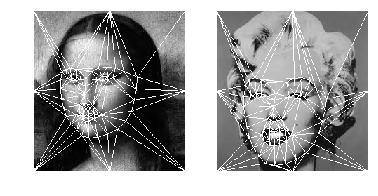

In [10]:
Show_Triangulation(im1, im2)

## Morphing

<p style="text-align:justify;">Ahora aplicamos la función de Morphing para generar una secuencia de imágenes que nos brinde el efecto de transformación de un rostro a otro por medio del cálculo de un $\alpha$ que nos brinda la triangulación y sobreposición para la presentación de las imágenes durante su proceso de transformación </p>

In [11]:
Morphing(im1, im2, n=16, dirgif=dirname)

<p style="text-align:justify;"> Creamos la animación con ayuda de la librería <i>imageio</i> a partir de las imágenes obtenidas con la función de Morphing y la visualizamos en el notebook con ayuda de la función Image librería <i>IPython</i> en el módulo <i>display</i>.</p>

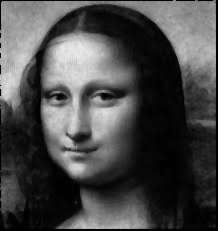

In [12]:
Crea_GIF(dirgif=dirname, namegif = namegif)
Show_GIF(namegif, viso = namegif + '.png')

# Proyecto

* Completa las tareas para realizar el morphing de las dos imágenes en este notebook.
* Captura una imagen de tu rostro y una de algún compañero y realiza el morphing de ambas.
* Construye una imagen gif animada para mostrar el morphing de ambas imágenes.

## Aplicación del Morphing a las imágenes del Proyecto
<br>
<p> Ahora aplicamos lo mismo pero con diferentes imágenes para probar las funciones, cargamos las imágenes a trabajar, esta vez redimensionamos la primera imagen ya que el ancho de la segunda es mayor, por lo cual si se reduce queda de una forma algo extraña.</p>

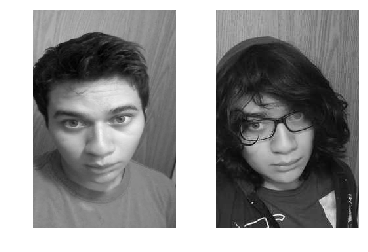

In [13]:
im1 = cv2.imread("jj1c.jpg",0)
im2 = cv2.imread("jj2c.jpg",0)
im1 = cv2.resize(im1,(im2.shape[1],im2.shape[0]))
namegif = 'jjmorphing.gif'
Show_Imags(im1, im2)

## Detectar Rostros


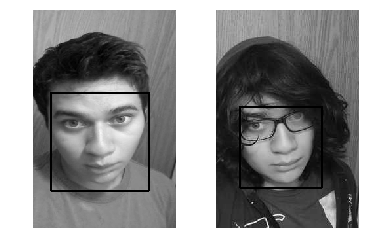

In [14]:
Show_Face_Detector(im1, im2)

## Recuperar puntos de interés
<br>
<p style="text-align:justify;">Podemos observar que los puntos de interés obtenidos en la segunda imagen difieren en la detección en la zona de los ojos, esto puede ser debido al uso de lentes, ya que hay múltiples factores que pueden afectar la eficacia del Algoritmo, esté es uno de esos casos especiales.</p>

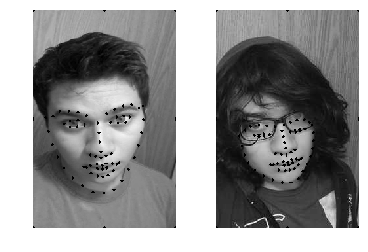

In [15]:
Show_Points_of_Interest(im1, im2)

## Triangulación de los puntos de interés
<br>
<p style="text-align:justify;">Ahora al ver la triangulación sobre ambas imágenes podemos visualizar de forma más clara la falla del Algoritmo de detección de rostros, ya que la zona de los ojos se considero como la parte inferior de los lentes, esto dara un efecto extraño durante el proceso de transición de la primera imagen a la segunda.</p>

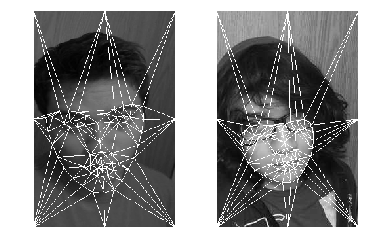

In [16]:
Show_Triangulation(im1, im2)

## Morphing

In [17]:
Morphing(im1, im2, n=16)

## Visualización del GIF animado

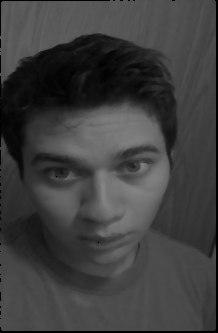

In [18]:
Crea_GIF()
Show_GIF(namegif)

# Conclusión

<p style="text-align:justify;">El desarrollo de este proyecto no fue complicado en comparación al parcial anterior ya que la mayoría de funciones para las tranformaciones geométricas fueron vistas en clases, así que debiamos adaptar de forma correcta toda la secuencia de instrucciones que componen a la función de <i>Morphing</i> lo cual no fue difícil ya que debiamos razonar con lógica la secuencia de pasos a seguir, lo más importante a destacar para la realización del Morphing es el tamaño de las imágenes, ya que durante las pruebas realizadas surgieron incovenientes con el tamaño de las matrices a operar o un error muy común fue el de <i>Singular Matrix</i>, la aplicación de la función <i>Morphing</i> se lleva a cabo cálculando valores de un $\alpha$ para obtener la triangulación de acuerdo a los valores de dicho $\alpha$ y de nivelar los niveles de transparencia durante la transición de una imagen a la otra, por lo cual fue necesario analizar de forma detalla que tipo de instrucciones debemos seguir ya que podríamos estar realizando operaciones de más que afecten el tiempo de recuperación de imágenes, esto significa un costo computacional alto ya que debemos considerar que las imágenes son matrices, y las operaciones con matrices de dimensiones grandes pueden llegar a tomar un tiempo de ejecución mayor a lo esperado. Para terminar podemos concluir que se aplicó de forma correcta el <i>Morphing</i> en las imágenes de Marilyn y la Mona ya que los rostros no muestran mucha diferencia entre sí, en comparación a los otras dos utilizadas posteriomente con pequeñas diferencias respecto a la primera aplicación de la función debido a la recuperación de los puntos de interés, esto falló debido al uso de los lentes en la segunda imagen.</p> 